In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Define the repository URL and the local directory where you want to clone/pull the repository
repo_url = 'https://github.com/aakashvardhan/s10-residual-ocp.git'
local_dir = '/content/s10-residual-ocp'



# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

# !git clone 'https://github.com/aakashvardhan/s10-residual-ocp.git'

Cloning into 's10-residual-ocp'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 95 (delta 43), reused 66 (delta 16), pack-reused 0
Receiving objects: 100% (95/95), 77.42 KiB | 2.87 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [3]:
import sys
sys.path.append('/content/s10-residual-ocp')
sys.path.append('/content/s10-residual-ocp/models')

In [ ]:
!pip install torch-lr-finder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.8 MB/s eta 0:00:00


In [ ]:
from config import get_config
config = get_config()
from main import main
import torch
from utils import set_seeds
from setup_cifar10 import setup_cifar10
from torch_lr_finder import LRFinder
from models.custom_resnet import CustomResNet
from models.model_utils import model_summary, adam_optimizer
import torch.nn as nn
set_seeds()

In [ ]:
config['epochs'] = 24
config['lr_scheduler'] = 'one_cycle'
config['lr'] = 0.001

CUDA Available? True


100%|██████████| 170498071/170498071 [00:01<00:00, 104121865.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
          Identity-2           [-1, 64, 32, 32]               0
          Identity-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
           Dropout-6           [-1, 64, 32, 32]               0
         ConvBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,728
         MaxPool2d-9          [-1, 128, 16, 16]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Drop

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-03


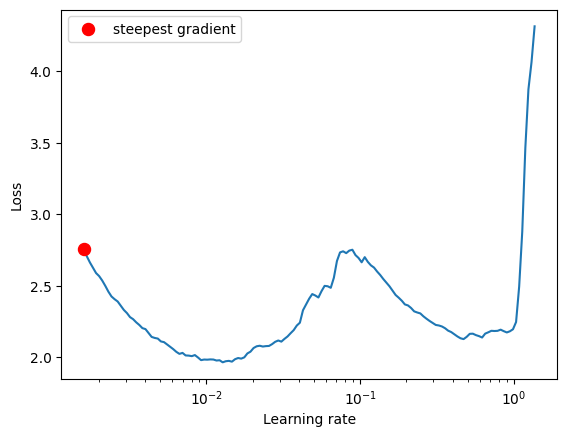

TypeError: cannot unpack non-iterable Axes object

In [ ]:
criterion = nn.CrossEntropyLoss()
train_data, test_data, train_loader, test_loader = setup_cifar10(config)
model = CustomResNet(config).to(config["device"])
model_summary(model, input_size=(3, 32, 32))
optimizer = adam_optimizer(model, config)
lr_finder = LRFinder(model, optimizer, criterion, device=config["device"])
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
_, max_lr = lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
config['max_lr'] = max_lr

In [ ]:
lr = main(config, model, train_loader, test_loader, optimizer, criterion)

In [ ]:
import matplotlib.pyplot as plt
from utils import plt_fig
plt_fig()

In [ ]:
from visualize import show_misclassified_images, plt_misclassified_images

In [ ]:
misclass_imgs, misclass_targets, misclass_preds = show_misclassified_images(model, test_loader, config)
plt_misclassified_images(config, misclass_imgs, misclass_targets, misclass_preds)